In [2]:
import findspark
findspark.init("C:\spark-3.0.0")

In [3]:
from pyspark import SparkContext
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

spark = SparkSession.builder \
    .master("local") \
    .appName("climateChange") \
    .getOrCreate()

In [5]:
spark

In [6]:
df = spark.read.csv("TemperaturesByCountry.csv",
                   header = True,
                   inferSchema = True,
                   sep = ",")

In [7]:
df.filter(df.Country == "Turkey").show()

+----------+------------------+-----------------------------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+------------------+-----------------------------+-------+
|1777-02-01|               3.0|                        3.314| Turkey|
|1777-03-01|              null|                         null| Turkey|
|1777-04-01| 7.678000000000001|                        2.553| Turkey|
|1777-05-01|            15.293|                        3.189| Turkey|
|1777-06-01|18.660999999999998|           2.9930000000000003| Turkey|
|1777-07-01|20.756999999999998|                        2.643| Turkey|
|1777-08-01|            21.561|           2.6010000000000004| Turkey|
|1777-09-01|            17.939|                        3.793| Turkey|
|1777-10-01|            11.046|                        4.003| Turkey|
|1777-11-01|             7.725|           2.7060000000000004| Turkey|
|1777-12-01|             3.225|                        2.757| Turkey|
|1778-01-01|        

In [8]:
turkey = df.filter(df.Country == "Turkey") 

In [9]:
turkey = turkey.toPandas()

In [10]:
turkey = turkey.drop(["AverageTemperatureUncertainty"], axis = 1)

In [11]:
turkey

,dt,AverageTemperature,Country
0,1777-02-01,3.000,Turkey
1,1777-03-01,NaN,Turkey
2,1777-04-01,7.678,Turkey
3,1777-05-01,15.293,Turkey
4,1777-06-01,18.661,Turkey
...,...,...,...
2835,2013-05-01,17.522,Turkey
2836,2013-06-01,20.862,Turkey
2837,2013-07-01,23.335,Turkey
2838,2013-08-01,23.839,Turkey


In [12]:
turkey = turkey.iloc[120:]

In [13]:
turkey =turkey.iloc[:-9]

In [14]:
turkey

,dt,AverageTemperature,Country
120,1787-02-01,1.758,Turkey
121,1787-03-01,5.665,Turkey
122,1787-04-01,9.114,Turkey
123,1787-05-01,15.138,Turkey
124,1787-06-01,20.516,Turkey
...,...,...,...
2826,2012-08-01,24.211,Turkey
2827,2012-09-01,21.021,Turkey
2828,2012-10-01,15.988,Turkey
2829,2012-11-01,10.001,Turkey


In [15]:
turkey.to_csv(r'turkey.csv')

In [16]:
df = pd.read_csv('turkey.csv')
df

,Unnamed: 0,dt,AverageTemperature,Country
0,120,1787-02-01,1.758,Turkey
1,121,1787-03-01,5.665,Turkey
2,122,1787-04-01,9.114,Turkey
3,123,1787-05-01,15.138,Turkey
4,124,1787-06-01,20.516,Turkey
...,...,...,...,...
2706,2826,2012-08-01,24.211,Turkey
2707,2827,2012-09-01,21.021,Turkey
2708,2828,2012-10-01,15.988,Turkey
2709,2829,2012-11-01,10.001,Turkey


In [17]:
df = df.loc[:, ~df.columns.str.match('Unnamed')]

In [18]:
#df = df.drop(["Country"],axis=1)
df

,dt,AverageTemperature,Country
0,1787-02-01,1.758,Turkey
1,1787-03-01,5.665,Turkey
2,1787-04-01,9.114,Turkey
3,1787-05-01,15.138,Turkey
4,1787-06-01,20.516,Turkey
...,...,...,...
2706,2012-08-01,24.211,Turkey
2707,2012-09-01,21.021,Turkey
2708,2012-10-01,15.988,Turkey
2709,2012-11-01,10.001,Turkey


In [19]:
#verimizi test ve train olarak ikiye ayırdık -test için 50 veri-
split_point = len(df) - 36
dataset, validation = df[0:split_point], df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
#dataset.to_csv('dataset.csv', index=False)
validation.round(3)
dataset.round(3)
dataset.to_csv('dataset_turkey.csv', index=False)
validation.to_csv('validation_turkey.csv', index=False)

Dataset 2675, Validation 36


In [20]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    
    print(diff)
    return numpy.array(diff)

In [21]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [22]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

series = pd.read_csv('dataset_turkey.csv', header=None)
#X değişkeni tahmin edilecek veriler
X = series[1].values
X = X[1:]
X = X.astype(np.float)
days_in_year = 365
differenced = difference(X, days_in_year)
#verilerimizi modele oturtuyoruz
model = ARIMA(differenced, order=(7,0,7))
model_fit = model.fit(disp=0)

print(model_fit.summary())

C:\Users\Onur\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Onur\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2310
Model:                     ARMA(7, 7)   Log Likelihood               -4687.714
Method:                       css-mle   S.D. of innovations              1.834
Date:                Mon, 30 Dec 2019   AIC                           9407.428
Time:                        13:45:53   BIC                           9499.348
Sample:                             0   HQIC                          9440.934
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0770        nan        nan        nan         nan         nan
ar.L1.y        0.4055    6.1e-06   6.65e+04      0.000       0.405       0.405
ar.L2.y        0.1377        nan        nan        n

C:\Users\Onur\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Onur\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Onur\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Onur\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [23]:
forecast = model_fit.forecast()[0]
forecast

array([-20.06200359])

In [24]:
forecast = inverse_difference(X, forecast, days_in_year)
print('Forecast: %f' % forecast)

Forecast: 3.474996


In [25]:
forecast = model_fit.forecast(steps=36)[0]

In [27]:
import pandas as pd
history = [x for x in X]
month = 1
predicted = np.array([])
validate = pd.read_csv(r"validation_turkey.csv")
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    predicted = np.append(predicted,inverted)
    print('Month %d: %f' % (month, inverted))
    history.append(inverted)
    month += 1

Month 1: 3.474996
Month 2: 3.386196
Month 3: 5.550561
Month 4: 11.468430
Month 5: 15.884929
Month 6: 19.240984
Month 7: 23.014208
Month 8: 22.234290
Month 9: 18.145797
Month 10: 13.070965
Month 11: 7.925098
Month 12: 4.778280
Month 13: 1.499560
Month 14: 0.921634
Month 15: 5.708597
Month 16: 11.258404
Month 17: 16.924289
Month 18: 22.347617
Month 19: 24.866104
Month 20: 24.639225
Month 21: 18.306031
Month 22: 11.190768
Month 23: 7.892851
Month 24: 3.653758
Month 25: 1.348186
Month 26: 2.823874
Month 27: 7.341038
Month 28: 8.634324
Month 29: 18.785935
Month 30: 21.937682
Month 31: 21.992804
Month 32: 21.584908
Month 33: 19.397454
Month 34: 13.060962
Month 35: 7.073438
Month 36: 1.588718


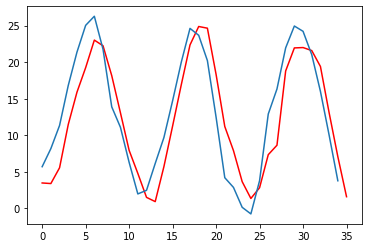

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
validate = pd.read_csv(r"validation_turkey.csv")
validate = validate.iloc[1:]
val = validate["AverageTemperature"].values
plt.plot(predicted,color="red")
plt.plot(val)

In [29]:
predicted = np.round_(predicted, decimals = 2)
predicted

array([ 3.47,  3.39,  5.55, 11.47, 15.88, 19.24, 23.01, 22.23, 18.15,
       13.07,  7.93,  4.78,  1.5 ,  0.92,  5.71, 11.26, 16.92, 22.35,
       24.87, 24.64, 18.31, 11.19,  7.89,  3.65,  1.35,  2.82,  7.34,
        8.63, 18.79, 21.94, 21.99, 21.58, 19.4 , 13.06,  7.07,  1.59])

In [30]:
dates = pd.read_csv('turkey.csv', header=0)
data = pd.read_csv('validation_turkey.csv', header=0)

In [31]:
dates = dates.drop(["AverageTemperature","Country"],axis = 1)

In [32]:
dates = dates.loc[:, ~dates.columns.str.match('Unnamed')]

In [33]:
dates = dates.iloc[-36:]

In [34]:
dates.index = pd.RangeIndex(len(dates.index))

dates.index = range(len(dates.index))

In [38]:
data = data.drop(["AverageTemperature","Country"],axis = 1)

KeyError: "['AverageTemperature' 'Country'] not found in axis"

In [39]:
dates["predicted"] = predicted

In [40]:
dates.to_csv(r'turkey_result.csv')

In [40]:
dates1 = dates["dt"]

In [41]:
dates1

0     2010-01-01
1     2010-02-01
2     2010-03-01
3     2010-04-01
4     2010-05-01
5     2010-06-01
6     2010-07-01
7     2010-08-01
8     2010-09-01
9     2010-10-01
10    2010-11-01
11    2010-12-01
12    2011-01-01
13    2011-02-01
14    2011-03-01
15    2011-04-01
16    2011-05-01
17    2011-06-01
18    2011-07-01
19    2011-08-01
20    2011-09-01
21    2011-10-01
22    2011-11-01
23    2011-12-01
24    2012-01-01
25    2012-02-01
26    2012-03-01
27    2012-04-01
28    2012-05-01
29    2012-06-01
30    2012-07-01
31    2012-08-01
32    2012-09-01
33    2012-10-01
34    2012-11-01
35    2012-12-01
Name: dt, dtype: object

In [42]:
spark.stop()

In [44]:
forecast2 = model_fit.forecast(steps = 120)[0]

In [46]:
import pandas as pd
history = [x for x in X]
month = 1
predicted = np.array([])
validate = pd.read_csv(r"validation.csv")
for yhat in forecast2:
    inverted = inverse_difference(history, yhat, days_in_year)
    predicted = np.append(predicted,inverted)
    print('Month %d: %f' % (month, inverted))
    history.append(inverted)
    month += 1

Month 1: 3.474996
Month 2: 3.386196
Month 3: 5.550561
Month 4: 11.468430
Month 5: 15.884929
Month 6: 19.240984
Month 7: 23.014208
Month 8: 22.234290
Month 9: 18.145797
Month 10: 13.070965
Month 11: 7.925098
Month 12: 4.778280
Month 13: 1.499560
Month 14: 0.921634
Month 15: 5.708597
Month 16: 11.258404
Month 17: 16.924289
Month 18: 22.347617
Month 19: 24.866104
Month 20: 24.639225
Month 21: 18.306031
Month 22: 11.190768
Month 23: 7.892851
Month 24: 3.653758
Month 25: 1.348186
Month 26: 2.823874
Month 27: 7.341038
Month 28: 8.634324
Month 29: 18.785935
Month 30: 21.937682
Month 31: 21.992804
Month 32: 21.584908
Month 33: 19.397454
Month 34: 13.060962
Month 35: 7.073438
Month 36: 1.588718
Month 37: 0.589767
Month 38: 2.714871
Month 39: 5.055755
Month 40: 8.336375
Month 41: 15.573624
Month 42: 18.640910
Month 43: 22.873576
Month 44: 22.773047
Month 45: 19.664145
Month 46: 13.806855
Month 47: 6.529515
Month 48: 3.012011
Month 49: 0.148234
Month 50: 1.751634
Month 51: 4.107071
Month 52: 10.6

In [47]:
predicted

array([ 3.47499641,  3.38619597,  5.55056149, 11.46843044, 15.88492861,
       19.24098355, 23.01420768, 22.23428971, 18.14579728, 13.07096452,
        7.92509829,  4.77828023,  1.4995605 ,  0.92163381,  5.70859699,
       11.25840424, 16.92428942, 22.3476167 , 24.86610426, 24.63922531,
       18.3060313 , 11.19076768,  7.89285124,  3.65375768,  1.34818641,
        2.82387376,  7.34103818,  8.63432407, 18.78593482, 21.937682  ,
       21.99280418, 21.58490819, 19.39745384, 13.06096224,  7.07343762,
        1.58871845,  0.58976702,  2.7148712 ,  5.05575458,  8.33637477,
       15.57362434, 18.64090956, 22.87357562, 22.77304738, 19.66414525,
       13.8068555 ,  6.52951475,  3.01201119,  0.14823424,  1.7516339 ,
        4.10707084, 10.60458079, 16.70036372, 23.2738079 , 25.38693517,
       23.78947826, 17.78561704, 13.40582121,  7.30065458,  2.94823359,
       -0.82725314,  3.1292877 ,  5.75756317, 10.2516566 , 13.41716689,
       23.03260859, 21.30643793, 21.06882396, 20.12310079, 15.04

In [48]:
series2 = pd.DataFrame([])

In [49]:
series2["PredictedValue"] = np.around(predicted, decimals=2)

In [50]:
dates = np.array(["2010-01"])

In [51]:
year = 2010
month = 2

In [52]:
while year<=2019:
    parse_dates = str(year)+"-"+str(month)
    dates = np.append(dates,parse_dates)
    if month >=12:
        month = 1
        year+= 1
    else:
        month+=1


In [53]:
dates

array(['2010-01', '2010-2', '2010-3', '2010-4', '2010-5', '2010-6',
       '2010-7', '2010-8', '2010-9', '2010-10', '2010-11', '2010-12',
       '2011-1', '2011-2', '2011-3', '2011-4', '2011-5', '2011-6',
       '2011-7', '2011-8', '2011-9', '2011-10', '2011-11', '2011-12',
       '2012-1', '2012-2', '2012-3', '2012-4', '2012-5', '2012-6',
       '2012-7', '2012-8', '2012-9', '2012-10', '2012-11', '2012-12',
       '2013-1', '2013-2', '2013-3', '2013-4', '2013-5', '2013-6',
       '2013-7', '2013-8', '2013-9', '2013-10', '2013-11', '2013-12',
       '2014-1', '2014-2', '2014-3', '2014-4', '2014-5', '2014-6',
       '2014-7', '2014-8', '2014-9', '2014-10', '2014-11', '2014-12',
       '2015-1', '2015-2', '2015-3', '2015-4', '2015-5', '2015-6',
       '2015-7', '2015-8', '2015-9', '2015-10', '2015-11', '2015-12',
       '2016-1', '2016-2', '2016-3', '2016-4', '2016-5', '2016-6',
       '2016-7', '2016-8', '2016-9', '2016-10', '2016-11', '2016-12',
       '2017-1', '2017-2', '2017-3', '20

In [54]:
series3 = pd.DataFrame([])

In [55]:
series3["dates"] = dates

In [56]:
series3["predicted_value"] = series2["PredictedValue"]

In [57]:
series3

,dates,predicted_value
0,2010-01,3.47
1,2010-2,3.39
2,2010-3,5.55
3,2010-4,11.47
4,2010-5,15.88
...,...,...
115,2019-8,25.16
116,2019-9,23.20
117,2019-10,13.95
118,2019-11,7.56


In [58]:
series3.to_csv(r'turkey_long_results.csv')